In [60]:
%pip install git+https://github.com/tinnguyen197662/keras-vggface.git
%pip install pyyaml h5py

In [61]:
import numpy as np
import os
import os.path
import PIL
import tensorflow as tf
import keras
import keras_vggface
import keras_vggface.utils

In [62]:
from keras_vggface.vggface import VGGFace
import mtcnn
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
from keras.layers import Flatten, Dense, Input

In [63]:
vgg_face = VGGFace(model='resnet50', include_top=False,
                   input_shape=(224, 224, 3))
# print(vgg_face.summary())
print("Input: ", vgg_face.input)
print("Output: ", vgg_face.output)

Input:  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_16'), name='input_16', description="created by layer 'input_16'")
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 2048), dtype=tf.float32, name=None), name='avg_pool/AvgPool:0', description="created by layer 'avg_pool'")


In [64]:
import matplotlib.image as mpimg

sample_img = mpimg.imread(
    'data/train/TIN/20230413_161955.jpg').transpose(1, 0, 2)
print(sample_img.shape)

face_detector = mtcnn.MTCNN()
face_roi = face_detector.detect_faces(sample_img)

(3264, 2448, 3)
1/1 [==============================] - 0s 66ms/step


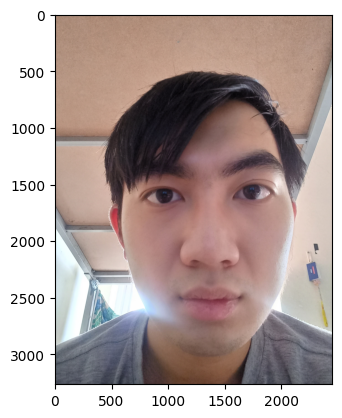

In [65]:
plt.imshow(sample_img)

(2150, 1600, 3)


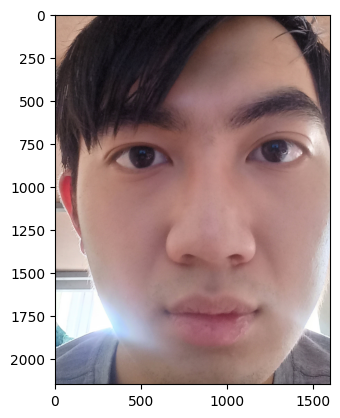

In [66]:
x1, y1, w, h = face_roi[0]['box']
x2, y2 = x1 + w, y1 + h
face = sample_img[y1:y2, x1:x2]
print(face.shape)
plt.imshow(face)

In [67]:
train_data = keras.utils.image_dataset_from_directory(
    'data/train', shuffle=True, batch_size=8, image_size=(224, 224))
test_data = keras.utils.image_dataset_from_directory(
    'data/test', shuffle=True, batch_size=8, image_size=(224, 224))

Found 80 files belonging to 2 classes.
Found 20 files belonging to 2 classes.


In [68]:
data_augmentation = keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
])

number_of_classes = 2  # 1 person + 1 everything else

vgg_face.trainable = False  # freeze the weights
last_layer = vgg_face.get_layer('avg_pool').output

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # randomly rotate/flip img
x = vgg_face(inputs)
x = Flatten(name='flatten')(x)
out = Dense(number_of_classes, activation='softmax', name='classifier')(x)
custom_model = keras.Model(inputs, out)

custom_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 classifier (Dense)          (None, 2)                 4098      
                                                                 
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [69]:
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = custom_model.fit(train_data, epochs=20)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 4s 175ms/step - loss: 0.5980 - accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - 2s 179ms/step - loss: 0.5518 - accuracy: 0.6375
Epoch 3/20
10/10 [==============================] - 2s 178ms/step - loss: 0.5121 - accuracy: 0.7875
Epoch 4/20
10/10 [==============================] - 2s 172ms/step - loss: 0.4743 - accuracy: 0.8375
Epoch 5/20
10/10 [==============================] - 2s 170ms/step - loss: 0.4435 - accuracy: 0.8625
Epoch 6/20
10/10 [==============================] - 2s 169ms/step - loss: 0.4154 - accuracy: 0.8750
Epoch 7/20
10/10 [==============================] - 2s 173ms/step - loss: 0.3905 - accuracy: 0.8750
Epoch 8/20
10/10 [==============================] - 2s 173ms/step - loss: 0.3672 - accuracy: 0.8750
Epoch 9/20
10/10 [==============================] - 2s 169ms/step - loss: 0.3470 - accuracy: 0.8750
Epoch 10/20
10/10 [==============================] - 2s 171ms/step - loss: 0.3280 - accuracy: 0.8875
Epoch 11/2

In [70]:
print(custom_model.metrics_names)
custom_model.evaluate(test_data, batch_size=5)

['loss', 'accuracy']
3/3 [==============================] - 1s 143ms/step - loss: 0.2492 - accuracy: 0.9500


[0.2491687834262848, 0.949999988079071]

In [73]:
custom_model.predict(test_data)

3/3 [==============================] - 1s 136ms/step


array([[0.78195363, 0.21804638],
       [0.63988185, 0.3601181 ],
       [0.00909149, 0.99090844],
       [0.16920336, 0.8307966 ],
       [0.6054207 , 0.3945792 ],
       [0.8178814 , 0.18211858],
       [0.803735  , 0.19626495],
       [0.2808108 , 0.71918917],
       [0.82092416, 0.17907579],
       [0.16287498, 0.837125  ],
       [0.23205772, 0.76794225],
       [0.8051228 , 0.19487724],
       [0.13976528, 0.86023474],
       [0.02859257, 0.9714074 ],
       [0.833623  , 0.16637698],
       [0.8156243 , 0.18437567],
       [0.04271456, 0.9572854 ],
       [0.8236247 , 0.17637536],
       [0.12148593, 0.8785141 ],
       [0.61745864, 0.3825413 ]], dtype=float32)

In [71]:
custom_model.save('./model/model.h5')

In [77]:
import tensorflow as tf
model = tf.keras.models.load_model('./model/model.h5')

In [79]:
from PIL import Image
import numpy as np

img = Image.open('./data/test/TIN/20230413_162149.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)

model.predict(img)

1/1 [==============================] - 0s 52ms/step


array([[0.5300026 , 0.46999738]], dtype=float32)